#Monitoreo de Calidad del Aire en Ciudades Inteligentes


## Fase 1: Preparación del modelo de ML de Regresión Logística

In [0]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType,StructField,LongType, StringType,DoubleType,TimestampType
from pyspark.sql.functions import col, when, window, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [0]:
schema = StructType( \
                     [StructField("Date", TimestampType(),True), \
                      StructField("Country", StringType(), True), \
                      StructField("Area_Type", StringType(), True), \
                      StructField('Emission_Source', StringType(), True), \
                      StructField('CO2_Concentration', DoubleType(), True), \
                      StructField('PM2.5', DoubleType(), True), \
                      StructField('PM10', DoubleType(), True), \
                      StructField('O3', DoubleType(), True), \
                      StructField('NOx', DoubleType(), True), \
                      StructField('SO2', DoubleType(), True), \
                      StructField('CO', DoubleType(), True), \
                      StructField('AQI', DoubleType(), True), \
                      StructField('Temperature', DoubleType(), True), \
                        ])

In [0]:
data = "dbfs:/FileStore/tables/proyecto/air_quality_data_1.csv"
df=spark.read.format('csv').option('header',True).schema(schema).load(data)
df.display()
df.printSchema()

Date,Country,Area_Type,Emission_Source,CO2_Concentration,PM2.5,PM10,O3,NOx,SO2,CO,AQI,Temperature
2024-06-20T00:00:00.000+0000,Germany,Rural,Residential,304.97,35.67,113.94,96.21,30.35,40.88,3.01,414.0,17.72
2023-10-20T00:00:00.000+0000,USA,Suburban,Natural,470.97,9.47,55.04,192.88,85.23,13.12,6.4,156.0,19.41
2023-12-03T00:00:00.000+0000,USA,Urban,Vehicular,430.95,65.84,80.38,89.37,28.39,14.16,5.47,248.0,38.5
2023-07-29T00:00:00.000+0000,China,Urban,Industrial,319.0,39.63,68.49,49.92,46.13,33.12,1.23,414.0,0.48
2024-04-06T00:00:00.000+0000,Germany,Rural,Industrial,409.22,25.44,16.66,131.51,84.94,32.49,8.74,57.0,-9.14
2023-09-20T00:00:00.000+0000,China,Urban,Residential,375.01,12.72,68.02,97.82,22.84,28.02,0.36,199.0,24.98
2023-12-26T00:00:00.000+0000,China,Rural,Vehicular,305.21,70.7,118.51,47.68,80.45,24.06,0.54,438.0,22.24
2023-12-18T00:00:00.000+0000,Brazil,Urban,Residential,352.9,36.01,13.67,151.79,27.32,5.53,4.21,77.0,9.08
2023-07-15T00:00:00.000+0000,India,Suburban,Natural,493.94,22.46,84.45,153.38,29.71,37.76,0.16,82.0,29.93
2023-10-21T00:00:00.000+0000,Germany,Urban,Industrial,300.7,5.2,114.64,61.14,72.47,46.23,9.1,377.0,38.79


root
 |-- Date: timestamp (nullable = true)
 |-- Country: string (nullable = true)
 |-- Area_Type: string (nullable = true)
 |-- Emission_Source: string (nullable = true)
 |-- CO2_Concentration: double (nullable = true)
 |-- PM2.5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- AQI: double (nullable = true)
 |-- Temperature: double (nullable = true)



La pregunta a la que responderá el modelo es: ¿El AQI será menor de 50? Ya que el rango aceptable de esta métrica para decir que tenemos un índice de calidad de aire bueno es de 0-50.
Por eso, el primer paso sera convertir la columna AQI en una etiqueta binaria (1 si AQI < 50, 0 si AQI >= 50)

In [0]:
df = df.withColumn("label", when(col("AQI") < 50, 1).otherwise(0))

In [0]:
df = df.withColumnRenamed("PM2.5", "PM2_5")

In [0]:
feature_columns = ["CO2_Concentration", "PM2_5", "PM10", "O3", "NOx", "SO2", "CO", "Temperature"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [0]:
pipeline = Pipeline(stages=[assembler, lr])

In [0]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [0]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=5)

In [0]:
cvModel = crossval.fit(train_data)

##Fase 2: Preparación de los datos

Generación de los datos ficticios en 20 datasets, estos tendrán aproximadamente 150 registros cada uno. Este código fue corrido en Jupiter Notebook.


In [0]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import shutil

# Generating synthetic data
countries = ["USA", "China", "India", "Germany", "Brazil"]
areas = ["Urban", "Suburban", "Rural"]
sources = ["Industrial", "Vehicular", "Natural", "Residential"]

# Generating dataframes
num_files = 20  
num_records_per_file = 150  # Average records per file

# Function to generate a single record
def generate_record():
    country = random.choice(countries)
    area = random.choice(areas)
    source = random.choice(sources)
    
    # Random dates within the last year
    date = datetime.now() - timedelta(days=random.randint(0, 365))
    
    # Random environmental measurements
    co2 = round(np.random.uniform(300, 500), 2)  # CO2 in ppm
    pm25 = round(np.random.uniform(0, 100), 2)  # PM2.5 in µg/m3
    pm10 = round(np.random.uniform(0, 150), 2)  # PM10 in µg/m3
    o3 = round(np.random.uniform(0, 200), 2)  # O3 in µg/m3
    nox = round(np.random.uniform(0, 100), 2)  # NOx in µg/m3
    so2 = round(np.random.uniform(0, 50), 2)  # SO2 in µg/m3
    co = round(np.random.uniform(0, 10), 2)  # CO in mg/m3
    aqi = random.randint(0, 500)  # AQI
    temperature = round(np.random.uniform(-10, 40), 2)  # Temperature in Celsius
    
    record = [date.strftime("%Y-%m-%d"), country, area, source, co2, pm25, pm10, o3, nox, so2, co, aqi, temperature]
    return record

# Columns for the dataframe
columns = ["Date", "Country", "Area_Type", "Emission_Source", "CO2_Concentration", "PM2.5", "PM10", "O3", "NOx", "SO2", "CO", "AQI", "Temperature"]

# Generate dataframes and save to CSV
for i in range(num_files):
    data = [generate_record() for _ in range(num_records_per_file)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(f"air_quality_data_{i+1}.csv", index=False)

# Create a zip file of the generated CSV
shutil.make_archive("air_quality_data", 'zip', ".", "air_quality_data_1.csv")  # Change this to include all generated files

Almacenamiento de Datos:Guardar cada parte de los datos en un directorio que será la fuente del stream de datos

In [0]:
%fs
ls dbfs:/FileStore/tables/proyecto

path,name,size,modificationTime
dbfs:/FileStore/tables/proyecto/air_quality_data_1.csv,air_quality_data_1.csv,12977,1719364296000
dbfs:/FileStore/tables/proyecto/air_quality_data_10.csv,air_quality_data_10.csv,12938,1719364298000
dbfs:/FileStore/tables/proyecto/air_quality_data_11.csv,air_quality_data_11.csv,12917,1719364298000
dbfs:/FileStore/tables/proyecto/air_quality_data_12.csv,air_quality_data_12.csv,13012,1719364298000
dbfs:/FileStore/tables/proyecto/air_quality_data_13.csv,air_quality_data_13.csv,12969,1719364298000
dbfs:/FileStore/tables/proyecto/air_quality_data_14.csv,air_quality_data_14.csv,12860,1719364299000
dbfs:/FileStore/tables/proyecto/air_quality_data_15.csv,air_quality_data_15.csv,12941,1719364299000
dbfs:/FileStore/tables/proyecto/air_quality_data_16.csv,air_quality_data_16.csv,12902,1719364299000
dbfs:/FileStore/tables/proyecto/air_quality_data_17.csv,air_quality_data_17.csv,12891,1719364299000
dbfs:/FileStore/tables/proyecto/air_quality_data_18.csv,air_quality_data_18.csv,12965,1719364296000


## Fase 3: Creación de la fuente de streaming

Creación de la Fuente: Utilizar el método readStream() para crear la fuente de datos para el stream, leyendo los datos desde el directorio mencionado anteriormente.

In [0]:
sourceStream=spark.readStream.format("csv").option("header",True).schema(schema).load("dbfs:/FileStore/tables/proyecto")

In [0]:
sourceStream= sourceStream.withColumnRenamed("PM2.5", "PM2_5")

Transformación con el Modelo: Aplicar el método transform() sobre el modelo de Regresión Logística previamente entrenado, pasando como parámetro el stream de fuente creado en el paso anterior.

In [0]:
stream_df = cvModel.transform(sourceStream)

Visualización del Stream: Utilizar el método display() para visualizar el stream de datos resultante.

In [0]:
stream_df.display()

Date,Country,Area_Type,Emission_Source,CO2_Concentration,PM2_5,PM10,O3,NOx,SO2,CO,AQI,Temperature,features,rawPrediction,probability,prediction
2023-10-12T00:00:00.000+0000,Germany,Urban,Residential,354.82,85.63,89.5,84.02,6.38,19.6,8.81,22.0,-2.48,"Map(vectorType -> dense, length -> 8, values -> List(354.82, 85.63, 89.5, 84.02, 6.38, 19.6, 8.81, -2.48))","Map(vectorType -> dense, length -> 2, values -> List(2.526923940052444, -2.526923940052444))","Map(vectorType -> dense, length -> 2, values -> List(0.9260078660752885, 0.07399213392471149))",0.0
2024-03-12T00:00:00.000+0000,China,Urban,Residential,423.96,14.89,7.87,18.28,17.65,22.36,8.43,459.0,37.19,"Map(vectorType -> dense, length -> 8, values -> List(423.96, 14.89, 7.87, 18.28, 17.65, 22.36, 8.43, 37.19))","Map(vectorType -> dense, length -> 2, values -> List(2.4223161671656226, -2.4223161671656226))","Map(vectorType -> dense, length -> 2, values -> List(0.9185132700037482, 0.08148672999625184))",0.0
2023-09-21T00:00:00.000+0000,USA,Rural,Residential,314.9,37.34,23.52,77.72,68.38,8.65,2.47,116.0,29.01,"Map(vectorType -> dense, length -> 8, values -> List(314.9, 37.34, 23.52, 77.72, 68.38, 8.65, 2.47, 29.01))","Map(vectorType -> dense, length -> 2, values -> List(2.1898318395529697, -2.1898318395529697))","Map(vectorType -> dense, length -> 2, values -> List(0.8993326833198251, 0.10066731668017492))",0.0
2024-04-06T00:00:00.000+0000,China,Rural,Vehicular,443.21,15.43,143.35,171.25,76.86,5.1,0.08,493.0,-3.32,"Map(vectorType -> dense, length -> 8, values -> List(443.21, 15.43, 143.35, 171.25, 76.86, 5.1, 0.08, -3.32))","Map(vectorType -> dense, length -> 2, values -> List(2.8938408339423822, -2.8938408339423822))","Map(vectorType -> dense, length -> 2, values -> List(0.9475411261697115, 0.052458873830288466))",0.0
2023-12-24T00:00:00.000+0000,Brazil,Suburban,Vehicular,364.16,0.03,72.94,73.2,61.69,21.02,3.43,328.0,-0.09,"Map(vectorType -> dense, length -> 8, values -> List(364.16, 0.03, 72.94, 73.2, 61.69, 21.02, 3.43, -0.09))","Map(vectorType -> dense, length -> 2, values -> List(2.609524190040675, -2.609524190040675))","Map(vectorType -> dense, length -> 2, values -> List(0.9314720306628264, 0.06852796933717364))",0.0
2024-06-19T00:00:00.000+0000,India,Rural,Natural,389.35,19.68,106.27,111.28,69.1,31.92,9.09,305.0,-3.86,"Map(vectorType -> dense, length -> 8, values -> List(389.35, 19.68, 106.27, 111.28, 69.1, 31.92, 9.09, -3.86))","Map(vectorType -> dense, length -> 2, values -> List(2.8844697037944655, -2.8844697037944655))","Map(vectorType -> dense, length -> 2, values -> List(0.9470733575796713, 0.05292664242032874))",0.0
2023-08-07T00:00:00.000+0000,USA,Rural,Residential,417.9,91.44,82.13,189.28,72.26,23.57,7.69,184.0,24.37,"Map(vectorType -> dense, length -> 8, values -> List(417.9, 91.44, 82.13, 189.28, 72.26, 23.57, 7.69, 24.37))","Map(vectorType -> dense, length -> 2, values -> List(2.470834599106629, -2.470834599106629))","Map(vectorType -> dense, length -> 2, values -> List(0.9220717564795109, 0.0779282435204891))",0.0
2023-11-20T00:00:00.000+0000,India,Urban,Industrial,317.57,21.52,100.62,133.18,22.16,2.34,8.48,361.0,-1.22,"Map(vectorType -> dense, length -> 8, values -> List(317.57, 21.52, 100.62, 133.18, 22.16, 2.34, 8.48, -1.22))","Map(vectorType -> dense, length -> 2, values -> List(2.7515729081423346, -2.7515729081423346))","Map(vectorType -> dense, length -> 2, values -> List(0.9400021203285873, 0.05999787967141268))",0.0
2023-12-14T00:00:00.000+0000,China,Suburban,Industrial,407.53,93.6,52.5,55.93,58.68,45.8,2.2,337.0,24.1,"Map(vectorType -> dense, length -> 8, values -> List(407.53, 93.6, 52.5, 55.93, 58.68, 45.8, 2.2, 24.1))","Map(vectorType -> dense, length -> 2, values -> List(1.9514946257425347, -1.9514946257425347))","Map(vectorType -> dense, length -> 2, values -> List(0.8756095241011699, 0.12439047589883012))",0.0
2024-06-18T00:00:00.000+0000,Germany,Suburban,Industrial,452.59,88.13,94.03,10.03,58.82,35.93,7.33,128.0,14.48,"Map(vectorType -> dense, 

## Fase 4: Implementación de una Consulta adicional

Crear una segunda consulta sobre el stream resultante del paso anterior:
Utilizar el método writeStream() con un modo de salida “append”, formato “memory” y nombre “calidadAireClassification”.

In [0]:
filtered_stream = stream_df.filter(col("AQI") < 50)

In [0]:
query = filtered_stream.writeStream \
                        .outputMode("append") \
                        .format("memory") \
                        .queryName("calidadAireClassification") \
                        .start()

## Fase 5: Evaluación del Modelo en streaming

Creación del Evaluador: Crear un objeto evaluador del tipo MulticlassClassificationEvaluator para obtener la métrica de "accuracy".

In [0]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

Generación de Dataframe: A partir de la consulta “calidadAireClassification”, generar un DataFrame utilizando spark.sql().

In [0]:
df_calidad_aire = spark.sql("SELECT * FROM calidadAireClassification")
df_calidad_aire.show()

+-------------------+-------+---------+---------------+-----------------+-----+------+------+-----+-----+----+----+-----------+--------------------+--------------------+--------------------+----------+
|               Date|Country|Area_Type|Emission_Source|CO2_Concentration|PM2_5|  PM10|    O3|  NOx|  SO2|  CO| AQI|Temperature|            features|       rawPrediction|         probability|prediction|
+-------------------+-------+---------+---------------+-----------------+-----+------+------+-----+-----+----+----+-----------+--------------------+--------------------+--------------------+----------+
|2023-10-12 00:00:00|Germany|    Urban|    Residential|           354.82|85.63|  89.5| 84.02| 6.38| 19.6|8.81|22.0|      -2.48|[354.82,85.63,89....|[2.52692394005244...|[0.92600786607528...|       0.0|
|2023-09-25 00:00:00|  India| Suburban|      Vehicular|           442.94| 3.53|  9.47|120.44| 6.58|33.66|1.57| 5.0|      19.69|[442.94,3.53,9.47...|[1.96092761717984...|[0.87663330683039...|  

Evaluación del Modelo: Pasar este DataFrame resultante como parámetro al evaluador utilizando el método evaluate().

In [0]:
accuracy = evaluator.evaluate(df_calidad_aire)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [0]:
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

precision = evaluator_precision.evaluate(df_calidad_aire)
recall = evaluator_recall.evaluate(df_calidad_aire)
f1 = evaluator_f1.evaluate(df_calidad_aire)

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## Fase opcional

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


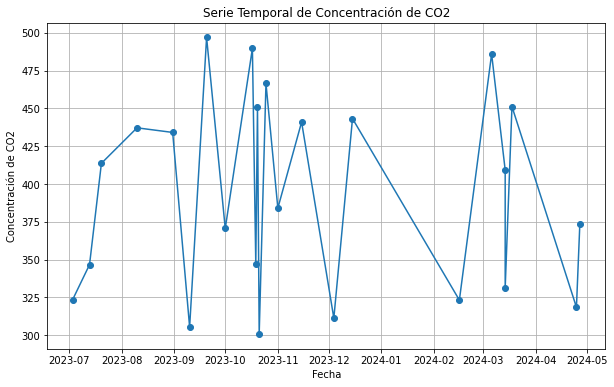

In [0]:
import matplotlib.pyplot as plt
stream_df = predictions.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(stream_df['Date'], stream_df['CO2_Concentration'], marker='o', linestyle='-')
plt.xlabel('Fecha')
plt.ylabel('Concentración de CO2')
plt.title('Serie Temporal de Concentración de CO2')
plt.grid(True)
plt.show()

El eje y muestra los niveles de concentración de CO2, con valores que van de 300 a 500 y los puntos azules conectados por líneas representan los datos observados en esas fechas.
El rango aceptable para este tipo de metrica es dentro de 300-400 por lo que con este grafico se pueden identificar cuales dias ha habido una mayor concentracion del CO2 disminuyendo la calidad del aire. 


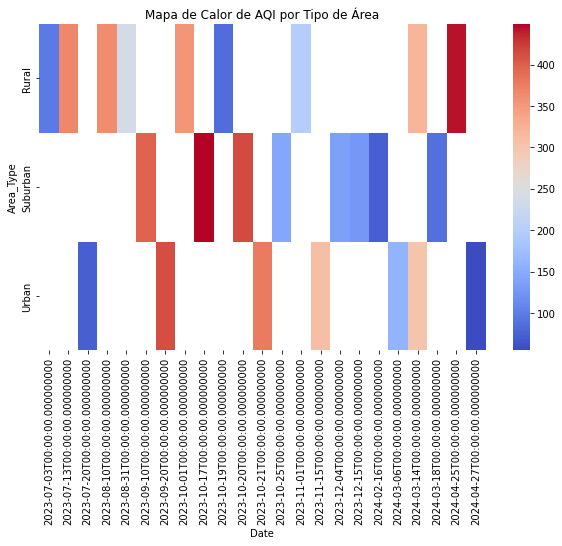

In [0]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(stream_df.pivot_table(index='Area_Type', columns='Date', values='AQI'), cmap='coolwarm')
plt.title('Mapa de Calor de AQI por Tipo de Área')
plt.show()

En funcion del grafico visualizado, vemos que el entorno de la ciudad no tiene gran relevancia en el indice de la calidad del aire debido a que son datos random, porque en estas ocasiones es recomendable deducir que si la ciudad es urbana deberia tener peores resultados de AQI. Mientras mayor es el AQI, peor es la calidad del aire en la zona siendo en este grafico un rango considerable menor a 200. 

In [0]:
for stream in spark.streams.active:
  stream.stop()